In [1]:
# Basics
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

# Janela de retornos usada para montar o portfólio
janela_retornos = 252
janela_rebal = 126

# Contrarian
str_dir = 'C:/Users/nelly/Desktop/Mestrado Insper/DISSERTAÇÃO/Dissertação/1. Modelo/'

# Importa base de retornos das ações do Ibovespa 
str_Retornos = 'Retornos'
    
df_Retornos = pd.read_csv(filepath_or_buffer = str_dir + str_Retornos + '.csv', sep=';')
df_Retornos.index = df_Retornos['Data']
df_Retornos = df_Retornos.drop(columns=['Data'])
df_Retornos = df_Retornos.dropna()
    
df_Retornos['indice']=np.zeros(len(df_Retornos.index))

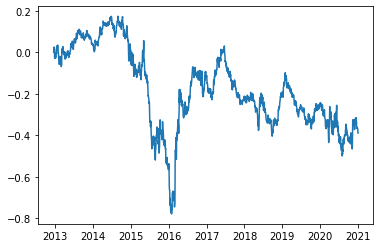

In [2]:
for x in range(0,len(df_Retornos.index)):
    df_Retornos.iloc[x,len(df_Retornos.columns)-1] = datetime.datetime(df_Retornos.iloc[x,2],df_Retornos.iloc[x,1], df_Retornos.iloc[x,0])
    
df_Retornos = df_Retornos.drop(columns=['Day', 'Month', 'Year'])
df_Retornos.index = df_Retornos['indice']
df_Retornos = df_Retornos.drop(columns=['indice'])

# Portfólio
n_stocks_total = len(df_Retornos.columns)
n_stocks_port = 10
df_Retornos_rol = df_Retornos.rolling(janela_retornos).sum().dropna()
df_Retornos_rol_rank = df_Retornos_rol.rank(axis = 1)
df_ones = pd.DataFrame(data = np.ones([df_Retornos_rol_rank.shape[0], df_Retornos_rol_rank.shape[1]]),
                       index = df_Retornos_rol_rank.index, columns = df_Retornos_rol.columns)
df_weights = (-1)*df_ones[df_Retornos_rol_rank>=(n_stocks_total-n_stocks_port)].fillna(0) + \
        1*df_ones[df_Retornos_rol_rank<=n_stocks_port].fillna(0)
df_weights = df_weights * (1/n_stocks_port)
t = 0
T = len(df_Retornos_rol)
df_weights_rebal = pd.DataFrame()
while t <= T:
    df_weights_aux = pd.DataFrame(data = df_weights.iloc[t,:])
    df_weights_aux = pd.concat([df_weights_aux.T]*np.min([janela_rebal, T-t]), axis = 0)
    df_weights_rebal = pd.concat([df_weights_rebal, df_weights_aux], axis = 0)
    t = t + janela_rebal
df_weights_rebal.index = df_weights.index
df_Retornos_contrarian = df_Retornos[df_Retornos.index.isin(df_weights_rebal.index)]
df_ret_port_contrarian = (df_weights_rebal.shift(-1).dropna() * df_Retornos_contrarian.iloc[1:,:]).sum(axis=1)

sns.lineplot(data = df_ret_port_contrarian.cumsum())

df_ret_port_contrarian.to_csv(str_dir + 'CONTRARIAN.csv')